In [6]:
from skimage import filters, img_as_float
from skimage.exposure import rescale_intensity
from skimage.morphology import disk

from scipy.ndimage.filters import gaussian_laplace


from scipy import fftpack

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd

import pims
import trackpy as tp

import progressbar

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

from skimage.feature import blob_dog, blob_log, blob_doh

from math import sqrt

from skimage.feature import peak_local_max
from scipy.stats import gumbel_r

import xml.etree.ElementTree as ET

In [2]:
# The blob_log function calls the helper function _prune_blobs to remove overlapping detected blobs
# This function is not accessible from the module, so I've just pasted the source code here
# We want to have access to _prune_blobs so that we can remove overlapping blobs when we combine the
# detected blobs across different thresholds - when we use a different threshold for each sigma, we're doing
# a call to blob_log for each sigma, but we then need to remove any overlaps between different sigmas.

import math
from scipy import spatial

def _compute_disk_overlap(d, r1, r2):
    """
    Compute fraction of surface overlap between two disks of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first disk.
    r2 : float
        Radius of the second disk.
    Returns
    -------
    fraction: float
        Fraction of area of the overlap between the two disks.
    """

    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = math.acos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = math.acos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -
            0.5 * sqrt(abs(a * b * c * d)))
    return area / (math.pi * (min(r1, r2) ** 2))


def _compute_sphere_overlap(d, r1, r2):
    """
    Compute volume overlap fraction between two spheres of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first sphere.
    r2 : float
        Radius of the second sphere.
    Returns
    -------
    fraction: float
        Fraction of volume of the overlap between the two spheres.
    Notes
    -----
    See for example http://mathworld.wolfram.com/Sphere-SphereIntersection.html
    for more details.
    """
    vol = (math.pi / (12 * d) * (r1 + r2 - d)**2 *
           (d**2 + 2 * d * (r1 + r2) - 3 * (r1**2 + r2**2) + 6 * r1 * r2))
    return vol / (4./3 * math.pi * min(r1, r2) ** 3)


def _blob_overlap(blob1, blob2):
    """Finds the overlapping area fraction between two blobs.
    Returns a float representing fraction of overlapped area.
    Parameters
    ----------
    blob1 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    blob2 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    Returns
    -------
    f : float
        Fraction of overlapped area (or volume in 3D).
    """
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)

    # extent of the blob is given by sqrt(2)*scale
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim

    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    if d > r1 + r2:
        return 0

    # one blob is inside the other, the smaller blob must die
    if d <= abs(r1 - r2):
        return 1

    if n_dim == 2:
        return _compute_disk_overlap(d, r1, r2)

    else:  # http://mathworld.wolfram.com/Sphere-SphereIntersection.html
        return _compute_sphere_overlap(d, r1, r2)


def _prune_blobs(blobs_array, overlap=0.5):
    """Eliminated blobs with area overlap.
    Parameters
    ----------
    blobs_array : ndarray
        A 2d array with each row representing 3 (or 4) values,
        ``(row, col, sigma)`` or ``(pln, row, col, sigma)`` in 3D,
        where ``(row, col)`` (``(pln, row, col)``) are coordinates of the blob
        and ``sigma`` is the standard deviation of the Gaussian kernel which
        detected the blob.
        This array must not have a dimension of size 0.
    overlap : float
        A value between 0 and 1. If the fraction of area overlapping for 2
        blobs is greater than `overlap` the smaller blob is eliminated.
    Returns
    -------
    A : ndarray
        `array` with overlapping blobs removed.
    """
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if _blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])


In [8]:
# Max's code for selecting a threshold
def thresh_llecdf_line(a, cutoff):
    params = gumbel_r.fit(a)
    x = np.sort(a)
    #Here y is the loglog of the fitted gumbel cdf
    y = -np.log(-np.log(gumbel_r.cdf(x,loc=params[0], scale=params[1])))
    i = np.max(np.where(y<cutoff))
    return(x[i])

### Implementing Max's Thresholding

We can use laplacian-of-gaussian blob detection to find events in each frame of a cell movie. After detection, we can then use particle tracking to link these events across frames.

For a specified standard deviation (representing blob size), the laplacian-of-gaussian method find blobs of the corresponding size by finding local maxima of the laplacian. To remove spurious "blobs" resulting from noise in background intensity, an intensity threshold can be specified so that blobs must have a minimum peak intensity to be detected. The question is, how to find this threshold?

Max has implemented an approach to choose the intensity threshold by comparing the empirical CDF of peak intensities to a specified extreme value distribution. Here we apply that approach to each frame of the movie. Since the threshold might change for different standard deviations in the laplacian-of-gaussian, we use a range of standard deviations for each frame, and use Max's approach to calculate a threshold for each of them. We then combine detected blobs across standard deviations for each frame, and remove overlaps. Finally, we track the resulting detected events across frames.

In [9]:
# Function to detect blobs in cell videos
# Returns a pandas data frame with columns for (x,y) location and frame number (0-indexed) for detected blobs
# The output of this function can then be the input for particle tracking to link blobs across frames

# f: array or list of frames from cell video
# thresh_func: function for choosing a threshold from local max values
# max_sigma: largest standard deviation considered for LoG blob detection
# min_sigma: smallest standard deviation considered for LoG blob detection
# num_sigma: number of standard deviations to try in blob detection
# cutoff: the cutoff used to find an intensity threshold in thresh_func

def find_locs(f, thresh_func = thresh_llecdf_line, max_sigma=2, min_sigma=1, num_sigma=11, cutoff=3):
    
    # Generate list of evenly-spaced standard deviations between min_sigma and max_sigma
    scale = np.linspace(0, 1, num_sigma)[:, None]
    sigma_list = scale * (max_sigma - min_sigma) + min_sigma
    sigma_list = sigma_list[:,0]
    
    # create a data frame to store the detected blobs
    locs = pd.DataFrame({'x' : [], 'y' : [], 'frame': []})
    
    bar = progressbar.ProgressBar()
    for idx, frame in bar(enumerate(f)):
        # Denoise the frame, apply laplacian for each standard deviation, and find
        # the local max values of the laplacian
        frame = denoise_wavelet(frame, multichannel=False)
        gls = [-gaussian_laplace(frame, sig) * sig **2 for sig in sigma_list]
        plm = [peak_local_max(x) for x in gls]
        plmval = [[gls[i][r,c] for (r,c) in plm[i]] for i in range(len(sigma_list))]
        
        # select the threshold separately for each sigma
        thresh = [thresh_func(pv, cutoff) for pv in plmval]
        
        # for each threshold, detect blobs in the current frame
        bls = np.concatenate([blob_log(frame, max_sigma=sigma_list[i], min_sigma=sigma_list[i],
                       num_sigma=1, threshold=thresh[i]) for i in range(len(sigma_list))])
        
        # remove overlapping blobs. The blob_log function does this for each sigma, but we need to
        # remove any overlaps between sigmas, since we used a different threshold (and hence a different
        # call to blob_log) for each sigma
        bls = _prune_blobs(bls)
        
        # record current frame number, rather than the sigma used in blob detection
        bls[:,2] = idx
        
        # Important note! blob_log function returns (row, col, sigma)
        # row corresponds to y and column to x
        bls = pd.DataFrame(bls, columns=['y', 'x', 'frame'])
        locs = locs.append(bls)
    
    # To do particle tracking across frames, after calling this function you would run the following:
    #
    # events = tp.link_df(locs, search_range=search_range, memory=memory)
    # events = tp.filter_stubs(events, track_length_min)
    #
    # for specified values of
    # search_range: restriction on number of pixels the particle can move from frame to frame
    # memory: number of frames the particle can disappear for
    # track_length_min: minimum number of frames a track must exist for 
    
    return locs

In [10]:
# import x coord, y coord, and frame number for all of the puffs identified in an xml file
# makes LOTS of assumptions about how the data are structured
# fix this later!
def import_xml_data(f):
    tree = ET.parse(f)
    root = tree.getroot()
    markers = root[1]
    marker_coords = []
    for m in markers[1]:
        if m.tag == 'Marker':
            marker_coords = marker_coords + [[int(m[0].text), int(m[1].text), int(m[2].text)]]
    
    return marker_coords

In [11]:
# for each event in the xml file (in order), either return the id of the event in the imported matlab file
# or return -1 if we can't find it in the matlab data
# df should be a pandas data frame
# loc is a triple of x coord, y coord, frame number
def filter_df(df, loc, radius=5):
    # match frame, and match (x,y) coords within radius
    id_list = df[(df['frame'] == (loc[2] - 1)) &  (np.abs(df['x'] - loc[0]) < radius) & 
       (np.abs(df['y'] - loc[1]) < radius)]['particle'].tolist()
    if not id_list:
        return - 1
    return id_list[0]

Now let's put this into action. We read in a cell movie and Zara's hand-labeled puff XML data. We then run blob detection to find the (x, y, frame) locations of detected events, and perform particle tracking to link across frames. We then compare Zara's hand-labeled puffs to our blob detection; for each hand-labeled puff, we search for it by matching (x,y) coordinates and frame number, returning the event id of the event in our tracked data if we did detect it.

In [14]:
# read in a video to analyze
f = pims.TiffStack('./videos/cell_3_30_hz.tif')

# read in the xml file containing puffs we want to find
marker_locs = import_xml_data('cell_3_30_hz_markers.xml')

In [31]:
# decreasing the cutoff, or increasing max_sigma, should make the detection more permissive and 
# therefore find a higher proportion of the hand-labeled puffs, at the cost of finding more events overall
locs = find_locs(f, cutoff=3, max_sigma=5)

/ |                          #                      | 240 Elapsed Time: 0:02:04/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
| |               #                                | 1799 Elapsed Time: 0:14:15


In [32]:
# particle tracking to link events across frames
events = tp.link_df(locs, search_range=3, memory=0)
events = tp.filter_stubs(events, 4)

Frame 1799: 246 trajectories present.


Now look for Zara's puffs. Even with a higher cutoff, it looks like we're able to find at least half of them.  We see several thousand detected events overall - we'll have to investigate to see what proportion of these are truly puffs.

In [33]:
# Check what proportion of hand-labeled puffs we detect in the video
# (we return -1 rather than the event id if we fail to find the puff with our blob detection and tracking)
puff_ids = np.array([filter_df(events, m, 5) for m in marker_locs])
(puff_ids[puff_ids > -1].shape[0] *1.0)/puff_ids.shape[0]

0.8095238095238095

In [34]:
# overall number of detected events with our blob detection
np.unique(events['particle']).shape

(18383,)

In [331]:
# we can look at which hand-labeled puffs we failed to detect
np.where(puff_ids == -1)

(array([15, 16, 19, 22, 23, 24, 26, 27, 28, 33, 39, 42, 46, 48, 50, 52, 55,
        56, 59]),)

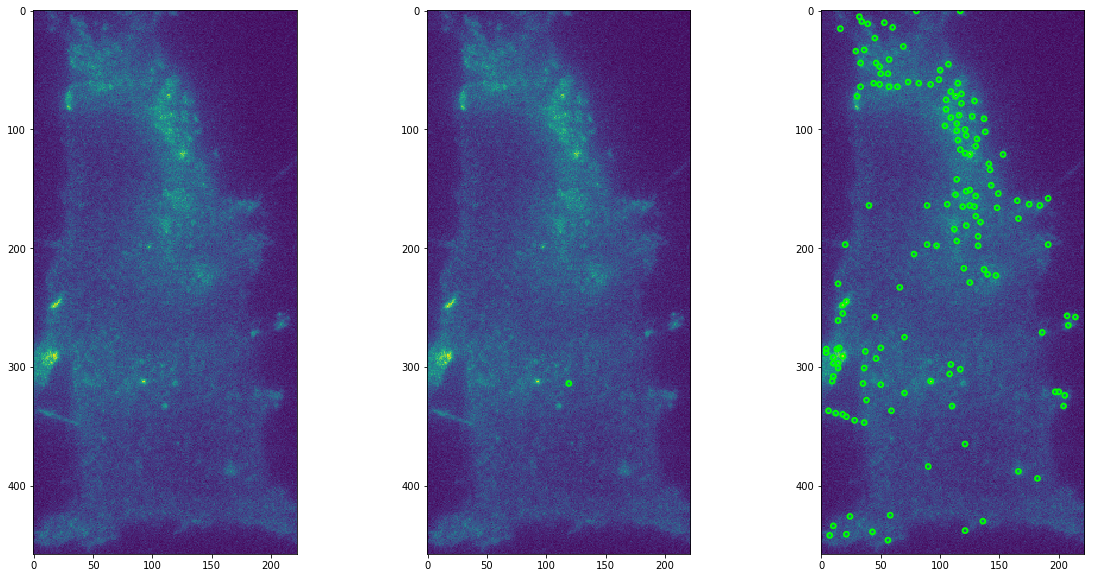

In [332]:
# why aren't we picking up some blobs?
# could be our radius is too small
# or the blobs are too dim

ii = 42 # id of puff in the hand-labeled xml puff data that we want to examine

fig, axs = plt.subplots(1,3, figsize=(20,10))

x, y, fn = marker_locs[ii]

axs[0].imshow(f[fn-1])
axs[1].imshow(f[fn-1])
axs[2].imshow(f[fn-1])

event_subset = np.array(events[events['frame'] == (fn-1)])

c = plt.Circle((x, y), 2, color='lime', linewidth=2, fill=False)
axs[1].add_patch(c)

for blob in event_subset:
    _, x, y, _ = blob
    c = plt.Circle((x, y), 2, color='lime', linewidth=2, fill=False)
    axs[2].add_patch(c)

plt.show()